# A Python Tour of Data Science: Data Exploitation

[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

In [1]:
# Cross-platform (Windows / Mac / Linux) paths.
import os.path
folder = os.path.join('..', 'data', 'credit_card_defaults')

import numpy as np
X = np.load(os.path.join(folder, 'X.npy'))
y = np.load(os.path.join(folder, 'y.npy'))
n, d = X.shape
print('The data is a {} with {} samples of dimensionality {}.'.format(type(X), n, d))

The data is a <class 'numpy.ndarray'> with 29946 samples of dimensionality 23.


## 1 Pre-Processing

Back to [NumPy](http://www.numpy.org/), the fundamental package for scientific computing with Python. It provides multi-dimensional arrays, data types and linear algebra routines. Note that [scikit-learn](http://scikit-learn.org) provides many helpers for those tasks.

Pre-processing usually consists of:
1. Data types transformation. The data has not necessarilly the format the chosen learning algorithm expects. This was done in the previous notebook before doing statistics with `statsmodels`.
1. Data normalization. Some algorithms expect data to be centered and scaled. Some will train faster.
1. Data randomization. If the samples are presented in sequence, it'll train faster if they are not correlated.
1. Train / test splitting. You may have to be careful here, e.g. not including future events in the training set.

In [2]:
# Center and scale.
# Note: on a serious project, should be done after train / test split.
X = X.astype(np.float)
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [3]:
# Training and testing sets.
test_size = 10000
print('Split: {} testing and {} training samples'.format(test_size, y.size - test_size))
perm = np.random.permutation(y.size)
X_test  = X[perm[:test_size]]
X_train = X[perm[test_size:]]
y_test  = y[perm[:test_size]]
y_train = y[perm[test_size:]]

Split: 10000 testing and 19946 training samples


## 2 A first Predictive Model

The ingredients of a Machine Learning (ML) model are:
1. A predictive function, e.g. the linear transformation $f(x) = x^Tw + b$.
1. An error function, e.g. the least squares $E = \sum_{i=1}^n \left( f(x_i) - y_i \right)^2 = \| f(X) - y \|_2^2$.
1. An optional regularization, e.g. the Thikonov regularization $R = \|w\|_2^2$.
1. Which makes up the loss / objective function $L = E + \alpha R$.

Our model has a sole hyper-parameter, $\alpha \geq 0$, which controls the shrinkage.

A Machine Learning (ML) problem can often be cast as a (convex or smooth) optimization problem which objective is to find the parameters (here $w$ and $b$) who minimize the loss, e.g.
$$\hat{w}, \hat{b} = \operatorname*{arg min}_{w,b} L = \operatorname*{arg min}_{w,b} \| Xw + b - y \|_2^2 + \alpha \|w\|_2^2.$$

If the problem is convex and smooth, one can compute the gradients
$$\frac{\partial L}{\partial{w}} = 2 X^T (Xw+b-y) + 2\alpha w,$$
$$\frac{\partial L}{\partial{b}} = 2 \sum_{i=1}^n (x_i^Tw+b-y_i) = 2 \sum_{i=1}^n (x_i^Tw-y_i) + 2n \cdot b,$$

which can be used in a [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) scheme or to form closed-form solutions:
$$\frac{\partial L}{\partial{w}} = 0 \ \rightarrow \ 2 X^T X\hat{w} + 2\alpha \hat{w} = 2 X^T y - 2 X^T b \ \rightarrow \ \hat{w} = (X^T X + \alpha I)^{-1} X^T (y-b),$$
$$\frac{\partial L}{\partial{b}} = 0 \ \rightarrow \ 2n\hat{b} = 2\sum_{i=1}^n (y_i) - \underbrace{2\sum_{i=1}^n (x_i^Tw)}_{=0 \text{ if centered}} \ \rightarrow \ \hat{b} = \frac1n I^T y = \operatorname{mean}(y).$$

What if the resulting problem is non-smooth ? See the [PyUNLocBoX](http://pyunlocbox.readthedocs.io), a convex optimization toolbox which implements [proximal splitting methods](https://en.wikipedia.org/wiki/Proximal_gradient_method).

### 2.1 Take a *symbolic* Derivative

Let's verify our manually derived gradients ! [SymPy](http://www.sympy.org/) is our computer algebra system (CAS) (like [Mathematica](https://www.wolfram.com/mathematica), [Maple](https://www.maplesoft.com/products/Maple)) of choice.

In [4]:
import sympy as sp
sp.init_printing()

X, y, w, b, a = sp.symbols('x y w b a')
L = (X*w + b - y)**2 + a*w**2

dLdw = sp.diff(L, w)
dLdb = sp.diff(L, b)

from IPython.display import display
display(L)
display(dLdw)
display(dLdb)

### 2.2 Build the Classifier

Relying on the derived equations, we can implement our model relying only on the [NumPy](http://www.numpy.org/) linear algebra capabilities (really wrappers to [BLAS](http://www.netlib.org/blas) / [LAPACK](http://www.netlib.org/lapack) implementations such as [ATLAS](http://math-atlas.sourceforge.net), [OpenBLAS](http://www.openblas.net) or [MKL](https://software.intel.com/intel-mkl)).

A ML model is best represented as a class, with hyper-parameters and parameters stored as attributes, and is composed of two essential methods:
1. `y_pred = model.predict(X_test)`: return the predictions $y$ given the features $X$.
1. `model.fit(X_train, y_train)`: learn the model parameters such as to predict $y$ given $X$.

In [5]:
class RidgeRegression(object):
    """Our ML model."""
    
    def __init__(self, alpha=0):
        "The class' constructor. Initialize the hyper-parameters."
        self.a = alpha
    
    def predict(self, X):
        """Return the predicted class given the features."""
        return np.sign(X.dot(self.w) + self.b)
    
    def fit(self, X, y):
        """Learn the model's parameters given the training data, the closed-form way."""
        n, d = X.shape
        self.b = np.mean(y)
        Ainv = np.linalg.inv(X.T.dot(X) + self.a * np.identity(d))
        self.w = Ainv.dot(X.T).dot(y - self.b)

    def loss(self, X, y, w=None, b=None):
        """Return the current loss.
        This method is not strictly necessary, but it provides
        information on the convergence of the learning process."""
        w = self.w if w is None else w  # The ternary conditional operator
        b = self.b if b is None else b  # makes those tests concise.
        import autograd.numpy as np  # See below for autograd.
        return np.linalg.norm(np.dot(X, w) + b - y)**2 + self.a * np.linalg.norm(w, 2)**2

Now that our model can learn its parameters and predict targets, it's time to evaluate it. Our metric for binary classification is the accuracy, which gives the percentage of correcly classified test samples. Depending on the application, the time spent for inference or training might also be important.

In [6]:
def accuracy(y_pred, y_true):
    """Our evaluation metric, the classification accuracy."""
    return np.sum(y_pred == y_true) / y_true.size

def evaluate(model):
    """Helper function to instantiate, train and evaluate the model.
    It returns the classification accuracy, the loss and the execution time."""
    import time
    t = time.process_time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy(y_pred, y_test)
    loss = model.loss(X_test, y_test)
    t = time.process_time() - t
    print('accuracy: {:.2f}%, loss: {:.2f}, time: {:.2f}ms'.format(acc*100, loss, t*1000))
    return model

alpha = 1e-2*n
model = RidgeRegression(alpha)
evaluate(model)

models = []
models.append(model)

accuracy: 80.12%, loss: 6039.06, time: 31.88ms


Okay we got around 80% accuracy with such a simple model ! Inference and training time looks good.

For those of you who don't now about numerical mathematics, solving a linear system of equations by inverting a matrix can be numerically instable. Let's do it the proper way and use a proper solver.

In [7]:
def fit_lapack(self, X, y):
    """Better way (numerical stability): solve the linear system with LAPACK."""
    n, d = X.shape
    self.b = np.mean(y)
    A = X.T.dot(X) + self.a * np.identity(d)
    b = X.T.dot(y - self.b)
    self.w = np.linalg.solve(A, b)

# Let's monkey patch our object (Python is a dynamic language).
RidgeRegression.fit = fit_lapack

# Yeah just to be sure.
models.append(evaluate(RidgeRegression(alpha)))
assert np.allclose(models[-1].w, models[0].w)

accuracy: 80.12%, loss: 6039.06, time: 12.73ms


### 2.3 Learning as Gradient Descent

Descending the gradient of our objective will lead us to a local minimum. If the objective is convex, that minimum will be global. Let's implement the gradient computed above and a simple gradient descent algorithm
$$w^{(t+1)} = w^{(t)} - \gamma \frac{\partial L}{\partial w}$$
where $\gamma$ is the learning rate, another hyper-parameter.

In [8]:
class RidgeRegressionGradient(RidgeRegression):
    """This model inherits from `ridge_regression`. We overload the constructor, add a gradient
    function and replace the learning algorithm, but don't touch the prediction and loss functions."""
    
    def __init__(self, alpha=0, rate=0.1, niter=1000):
        """Here are new hyper-parameters: the learning rate and the number of iterations."""
        super().__init__(alpha)
        self.rate = rate
        self.niter = niter
        
    def grad(self, X, y, w):
        A = X.dot(w) + self.b - y
        return 2 * X.T.dot(A) + 2 * self.a * w
        
    def fit(self, X, y):
        n, d = X.shape
        self.b = np.mean(y)
        
        self.w = np.random.normal(size=d)
        for i in range(self.niter):
            self.w -= self.rate * self.grad(X, y, self.w)
            
            # Show convergence.
            if i % (self.niter//10) == 0:
                print('loss at iteration {}: {:.2f}'.format(i, self.loss(X, y)))
            
models.append(evaluate(RidgeRegressionGradient(alpha, 1e-6)))

loss at iteration 0: 329242.23
loss at iteration 100: 14007.48
loss at iteration 200: 12709.08
loss at iteration 300: 12422.96
loss at iteration 400: 12282.00
loss at iteration 500: 12202.43
loss at iteration 600: 12155.28
loss at iteration 700: 12126.69
loss at iteration 800: 12109.11
loss at iteration 900: 12098.19
accuracy: 80.10%, loss: 6043.24, time: 2005.52ms


Tyred of derivating gradients by hand ? Welcome [autograd](https://github.com/HIPS/autograd/), our tool of choice for [automatic differentation](https://en.wikipedia.org/wiki/Automatic_differentiation). Alternatives are [Theano](http://deeplearning.net/software/theano/) and [TensorFlow](https://www.tensorflow.org/).

In [9]:
class RidgeRegressionAutograd(RidgeRegressionGradient):
    """Here we derive the gradient during construction and update the gradient function."""
    def __init__(self, *args):
        super().__init__(*args)
        from autograd import grad
        self.grad = grad(self.loss, argnum=2)

models.append(evaluate(RidgeRegressionAutograd(alpha, 1e-6)))

loss at iteration 0: 369004.56
loss at iteration 100: 17165.10
loss at iteration 200: 15181.22
loss at iteration 300: 14218.94
loss at iteration 400: 13598.31
loss at iteration 500: 13169.91
loss at iteration 600: 12867.13
loss at iteration 700: 12650.72
loss at iteration 800: 12495.00
loss at iteration 900: 12382.43
accuracy: 80.25%, loss: 6198.22, time: 2995.56ms


### 2.4 Learning as generic Optimization

Sometimes we don't want to implement the optimization by hand and would prefer a generic optimization algorithm. Let's make use of [SciPy](https://www.scipy.org/), which provides high-level algorithms for, e.g. [optimization](http://docs.scipy.org/doc/scipy/reference/optimize.html), [statistics](http://docs.scipy.org/doc/scipy/reference/stats.html), [interpolation](http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html), [signal processing](http://docs.scipy.org/doc/scipy/reference/tutorial/signal.html), [sparse matrices](http://docs.scipy.org/doc/scipy/reference/sparse.html), [advanced linear algebra](http://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html).

In [10]:
class RidgeRegressionOptimize(RidgeRegressionGradient):
    
    def __init__(self, alpha=0, method=None):
        """Here's a new hyper-parameter: the optimization algorithm."""
        super().__init__(alpha)
        self.method = method
    
    def fit(self, X, y):
        """Fitted with a general purpose optimization algorithm."""
        n, d = X.shape
        self.b = np.mean(y)
        
        # Objective and gradient w.r.t. the variable to be optimized.
        f = lambda w: self.loss(X, y, w)
        jac = lambda w: self.grad(X, y, w)
        
        # Solve the problem !
        from scipy.optimize import minimize
        w0 = np.random.normal(size=d)
        res = minimize(f, w0, method=self.method, jac=jac)
        self.w = res.x

models.append(evaluate(RidgeRegressionOptimize(alpha, method='Nelder-Mead')))
models.append(evaluate(RidgeRegressionOptimize(alpha, method='BFGS')))

/usr/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


accuracy: 73.47%, loss: 13773.20, time: 6211.07ms
accuracy: 80.12%, loss: 6039.06, time: 147.19ms


Accuracy may be lower (depending on the random initialization) as the optimization may not have converged to the global minima. Training time is however much longer ! Especially for gradient-less optimizers such as Nelder-Mead.

## 3 More interactivity

Interlude: the interactivity of Jupyter notebooks can be pushed forward with [IPython widgets](https://ipywidgets.readthedocs.io). Below, we construct a slider for the model hyper-parameter $\alpha$, which will train the model and print its performance at each change of the value. Handy when exploring the effects of hyper-parameters ! Although it's less usefull if the required computations are long.

In [11]:
import ipywidgets
from IPython.display import clear_output

slider = ipywidgets.widgets.FloatSlider(
    value=-2,
    min=-4,
    max=2,
    step=1,
    description='log(alpha) / n',
)

def handle(change):
    """Handler for value change: fit model and print performance."""
    value = change['new']
    alpha = np.power(10, value) * n
    clear_output()
    print('alpha = {:.2e}'.format(alpha))
    evaluate(RidgeRegression(alpha))

slider.observe(handle, names='value')
display(slider)

slider.value = 1  # As if someone moved the slider.

alpha = 2.99e+05
accuracy: 78.12%, loss: 6819.31, time: 6.25ms


## 4 Machine Learning made easier

Tired of writing algorithms ? Try [scikit-learn](http://scikit-learn.org), which provides many ML algorithms and related tools, e.g. metrics, cross-validation, model selection, feature extraction, pre-processing, for [predictive modeling](https://en.wikipedia.org/wiki/Predictive_modelling).

In [12]:
from sklearn import linear_model, metrics

# The previously developed model: Ridge Regression.
model = linear_model.RidgeClassifier(alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
models.append(model)

# Evaluate the predictions with a metric: the classification accuracy.
acc = metrics.accuracy_score(y_test, y_pred)
print('accuracy: {:.2f}%'.format(acc*100))

# It does indeed learn the same parameters.
assert np.allclose(models[-1].coef_, models[0].w, rtol=1e-1)

accuracy: 80.13%


In [13]:
# Let's try another model !
models.append(linear_model.LogisticRegression())
models[-1].fit(X_train, y_train)
acc = models[-1].score(X_test, y_test)
print('accuracy: {:.2f}%'.format(acc*100))

accuracy: 81.14%


## 5 Deep Learning (DL)

Of course ! We got two low-level Python libraries: (1) [TensorFlow](https://www.tensorflow.org/) and (2) [Theano](http://deeplearning.net/software/theano/). Both of them treat data as tensors and construct a computational graph ([dataflow paradigm](https://en.wikipedia.org/wiki/Dataflow_programming)), composed of any mathematical expressions, that get evaluated on CPUs or GPUs. Theano is the pioneer and features an optimizing compiler which will turn the computational graph into efficient code. TensorFlow has a cleaner API (not need to define expressions as strings) and does not require a compilation step (which is painful when developing models).

While you'll only use Theano / TensorFlow to develop DL models, these are the higher-level libraries you'll use to define and test DL architectures on your problem:
* [Keras](https://keras.io/): TensorFlow & Theano backends
* [Lasagne](http://lasagne.readthedocs.io): Theano backend
* [nolearn](https://github.com/dnouri/nolearn): sklearn-like abstraction of Lasagne
* [Blocks](http://blocks.readthedocs.io): Theano backend
* [TFLearn](http://tflearn.org): TensorFlow backend

In [14]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras

class NeuralNet(object):
    
    def __init__(self):
        """Define Neural Network architecture."""
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(output_dim=46, input_dim=23, activation='relu'))
        self.model.add(keras.layers.Dense(output_dim=1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    def fit(self, X, y):
        y = y / 2 + 0.5  # [-1,1] -> [0,1]
        self.model.fit(X, y, nb_epoch=5, batch_size=32)

    def predict(self, X):
        classes = self.model.predict_classes(X, batch_size=32)
        return classes[:,0] * 2 - 1
        
models.append(NeuralNet())
models[-1].fit(X_train, y_train)

loss_acc = models[-1].model.evaluate(X_test, y_test/2+0.5, batch_size=32)
print('\n\nTesting set: {}'.format(loss_acc))

Using Theano backend.


Epoch 1/5
19946/19946 [==============================] - 0s - loss: 0.5380 - acc: 0.7683     
Epoch 2/5
19946/19946 [==============================] - 0s - loss: 0.4853 - acc: 0.8027     
Epoch 3/5
19946/19946 [==============================] - 0s - loss: 0.4706 - acc: 0.8063     
Epoch 4/5
19946/19946 [==============================] - 0s - loss: 0.4623 - acc: 0.8097     
Epoch 5/5
 8064/10000 [=======================>......] - ETA: 0s

Testing set: [0.45383822469711305, 0.8105]


## 6 Evaluation

Now that we tried several predictive models, it is time to evaluate them with our chosen metrics and choose the one best suited to our particular problem. Let's plot the *classification accuracy* and the *prediction time* for each classifier with [matplotlib](http://matplotlib.org), the goto 2D plotting library for scientific Python. Its API is similar to matlab.

Result: The NeuralNet gives the best accuracy, by a small margin over the much simple logistic regression, but is the slowest method. Which to choose ? Again, it depends on your priorities.

 8960/10000 [=========================>....] - ETA: 0s

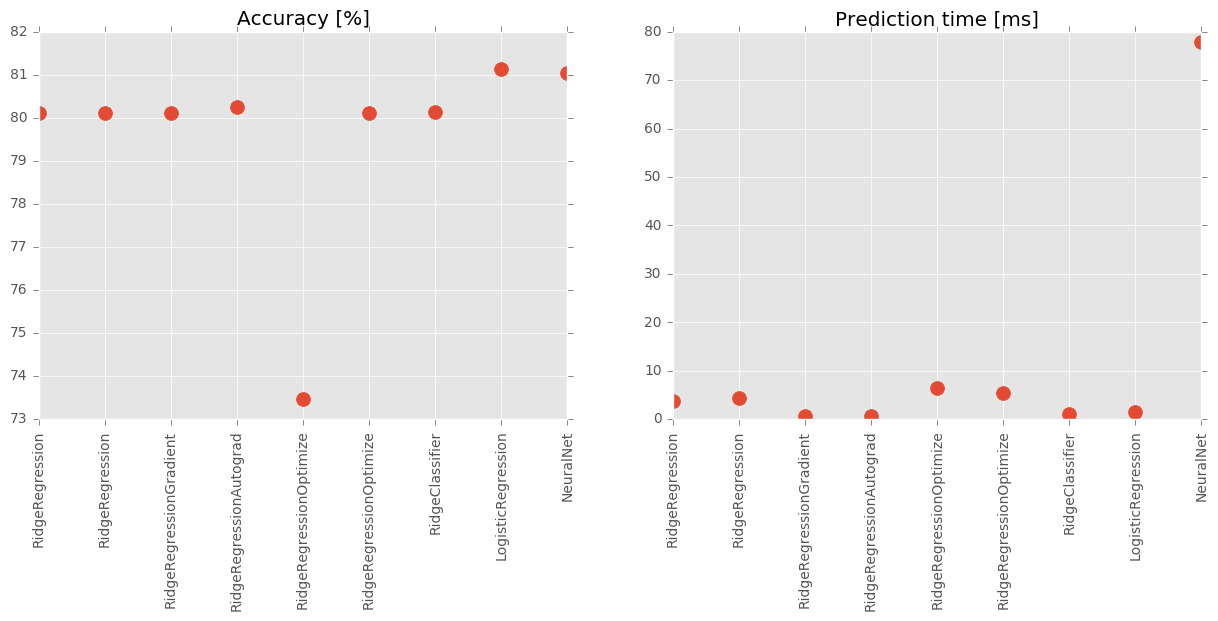

In [15]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
# Or notebook for interaction.

names, acc, times = [], [], []
for model in models:
    import time
    t = time.process_time()
    y_pred = model.predict(X_test)
    times.append((time.process_time()-t) * 1000)
    acc.append(accuracy(y_pred, y_test) * 100)
    names.append(type(model).__name__)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(acc, '.', markersize=20)
plt.title('Accuracy [%]')
plt.xticks(range(len(names)), names, rotation=90)

plt.subplot(122)
plt.plot(times, '.', markersize=20)
plt.title('Prediction time [ms]')
plt.xticks(range(len(names)), names, rotation=90)
plt.show()